# Impact of the k parameter - WBCD using Python

In this notebook we focus our analysis on the impact of the parameter k in the statistical conservation and the security level of the dataset.

We use the WBCD dataset

## Importation

In [2]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import time
import matplotlib.pyplot as plt
import seaborn as sns
import math

import zipfile

In [3]:
import multiprocessing


colors = pd.read_csv("../../color.csv", index_col=0)

In [4]:
def ml_results(clf, X_train, y_train, X_test, y_test):
    """
    perform machine learning results of the model clf

    return:
    - df_res: scores as a dataframe
    - df_roc: df of the roc curve
    - cm : cinfusion matrix
    """
    cm = pd.crosstab(y_test, clf.predict(X_test))
    TP = cm.iloc[0, 0]
    TN = cm.iloc[1, 1]
    FP = cm.iloc[0, 1]
    FN = cm.iloc[1, 0]
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) * 100
    specificity = TN / (TN + FP) * 100
    ppv = TP / (TP + FP) * 100
    npv = TN / (TN + FN) * 100
    auc = metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    fpr, tpr, thresholds = metrics.roc_curve(y_train, clf.predict_proba(X_train)[:, 1])
    df_roc = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})
    df_res = pd.DataFrame(
        [accuracy, sensitivity, specificity, ppv, npv, auc],
        index=["acc", "sens", "spec", "ppv", "npv", "auc"],
    )

    return df_res, df_roc, cm

In [5]:
def unique_SVM_model(
    X_train, y_train, X_test, y_test, X_test_ori, y_test_ori, order, parameters, nb_var
):
    """
    function that train a SVM model, found best parameters and return performance resutls and best parameters
    input :
        - X_train, y_train, X_test, y_test: typical datasets for training a ML model
        - order : the variables importance order
        - parameters :
        - nb_var : the number of feature selected for the model

    output :
        - best_params :parameters of the best model
        - cm: confusion matrix of the best model
        - df_res : performance of prediction results
        - df_roc: dataframe to draw ROC curve.
    """
    # train the model
    svc = SVC(probability=True)
    clf = GridSearchCV(svc, parameters, cv=5, n_jobs=11)
    clf.fit(X_train[order[0:nb_var]], y_train)
    best_params = clf.best_params_

    ### test the model
    # on avatar test
    res_avat, df_roc_avat, cm_avat = ml_results(
        clf, X_train[order[0:nb_var]], y_train, X_test[order[0:nb_var]], y_test
    )
    # on original test
    res_ori, df_roc_ori, cm_ori = ml_results(
        clf, X_train[order[0:nb_var]], y_train, X_test_ori[order[0:nb_var]], y_test_ori
    )

    return (best_params, cm_avat, res_avat, df_roc_avat, cm_ori, res_ori, df_roc_ori)

In [6]:
def preparation(df, iter, k):
    """
    small function which reshape and transform the df WBCD
    """
    df = df[df["iter_k"] == iter]
    df = df[df["k"] == k]
    df.drop(columns=["k", "id_ind", "iter_k"], axis=1, inplace=True)

    df.Class = df.Class.replace(2, 0)
    df.Class = df.Class.replace(4, 1)

    return df

## SVM computation

This section compare prediction performance using avatar and original data.


### On original data

For orginal data, we perform 100 different train/test 70/30 splits datasets.  
For each split we train a SVM model and test our model in the test section.

Computation is time consummming, results are save in a df and imported later.

In [7]:
df = pd.DataFrame(columns=[0, "test"])
df

,0,test


In [8]:
# load results FOR ORGINAL DATA
df = pd.read_csv("../../datasets/results_df/original_data_perf_wbcd.csv")



### On avatars data

We repeated 10 different avatarizations for each k with  `k  = {4 -> 334 by 30}`,   
and  compute SVM models and test it.

### Parameters

In [9]:
map_object = map(lambda val: 2 ** val, list(range(-5, 16)))
C_list = list(map_object)

map_object = map(lambda val: 2 ** val, list(range(-15, 3)))
gamma_list = list(map_object)

parameters = {"kernel": ["rbf"], "C": C_list, "gamma": gamma_list}

In [10]:
def loop_model(rep):
    """
    Function used in the parralelle computation
    """
    # Select subset df
    avatar_A = preparation(df_temp, rep, k)
    order = ["F6", "F3", "F2", "F7", "F1", "F8", "F5", "F4", "F9"]

    # split for model
    (
        avatar_A_X_train_70,
        avatar_A_X_test_30,
        avatar_A_y_train_70,
        avatar_A_y_test_30,
    ) = train_test_split(
        avatar_A.drop("Class", axis=1),
        avatar_A.Class,
        train_size=0.7,
        stratify=data.Class,
        random_state=40,
    )

    # train test the model
    start_time = time.time()
    (
        best_params_data_70_5,
        cm_avat_70_5,
        df_res_avat_70_5,
        df_roc_avat_70_5,
        cm_data_70_5,
        df_res_data_70_5,
        df_roc_data_70_5,
    ) = unique_SVM_model(
        X_train=avatar_A_X_train_70,
        y_train=avatar_A_y_train_70,
        X_test=avatar_A_X_test_30,
        y_test=avatar_A_y_test_30,
        X_test_ori=data_X_test_30,
        y_test_ori=data_y_test_30,
        order=order,
        parameters=parameters,
        nb_var=nb_feat,
    )
    end_time = time.time()
    print("k:", k, "iter : ", rep, (end_time - start_time) / 60)

    df = pd.concat([df_res_avat_70_5, df_res_data_70_5], axis=1).T
    df["test_type"] = ["avatar", "original"]
    df["k"] = k
    df["iter_k"] = rep

    return df

### Loop Computation

this loop is doing different svm model for different avatarized dataset, results were saved and load bellow.

### Import result data and do figure

In [11]:
result_k = pd.read_csv("../../datasets/results_df/accuracy_k_wbcd.csv")


# subset to plot onlu avatar train -avatar test
# (and remove avatar train, original test)
result_k = result_k[result_k["test_type"] == "avatar"]

## Result vizualisation  

We are here visualize the Area under the curve (AUC) according k value, and comparing the evolution of the ciurve with the original data results.

In [12]:
mean = df.groupby(["test"]).aggregate(["mean", "count", "std"])

ci95_hi = []
ci95_lo = []

for i in mean.index:
    m, c, s = mean.loc[i]
    ci95_hi.append(m + 1.95 * s / math.sqrt(c))
    ci95_lo.append(m - 1.95 * s / math.sqrt(c))

mean["ci95_hi"] = ci95_hi
mean["ci95_lo"] = ci95_lo



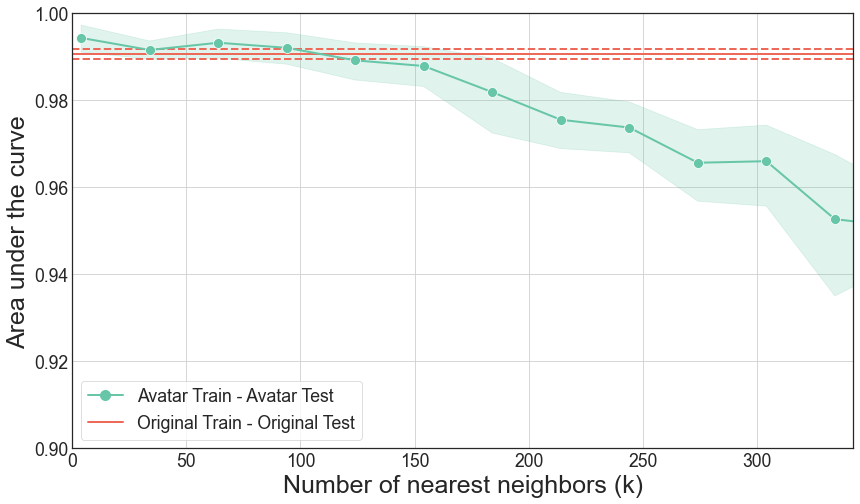

In [13]:
paper_rc = {"lines.linewidth": 2, "lines.markersize": 10}
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2, rc=paper_rc)
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"] = 1.25
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Helvetica"]
    fig = plt.figure(figsize=(14, 8))  # create a figure object
    ax1 = fig.add_subplot()


plt.axhline(y=mean.loc["auc", ("0", "mean")], color="#ED6A5A", linestyle="-")
plt.axhline(y=mean.loc["auc", ("ci95_hi", "")], color="#ED6A5A", linestyle="--")
plt.axhline(y=mean.loc["auc", ("ci95_lo", "")], color="#ED6A5A", linestyle="--")


sns.set_style("whitegrid")
ax = sns.lineplot(
    data=result_k,
    x="k",
    y="auc",
    ci=95,
    hue="test_type",
    style="test_type",
    err_style="band",
    markers=True,
    dashes=False,
    estimator="mean",
    palette=[colors.loc["avatar", "color"]],  # , '#1D1D1B'
)


handles, _ = ax.get_legend_handles_labels()
handles.append(plt.axhline(c="#ED6A5A", linestyle="solid"))

ax.set_xlabel("Number of nearest neighbors (k)", fontsize=25)
ax.set_ylabel("Area under the curve", fontsize=25)
ax.set(ylim=(0.90, 1), xlim=(0, 342))


legend = plt.legend(
    loc="lower left",
    frameon=1,
    title="",
    labels=["Avatar Train - Avatar Test", "Original Train - Original Test"],
    handles=handles[:],
)


plt.savefig("../../figure/WBCD_auc_variousK_70_30.svg", format="svg", dpi=600)

plt.show()